In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your dataset
df = pd.read_csv('Final_data.csv')

# Check for missing values
print(df.isnull().sum())

# Remove empty rows if any
df = df.dropna()

# Check class balance
print(df['label'].value_counts())

# Split into training and test sets
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


text     1
label    0
dtype: int64
label
1    1591
0     983
Name: count, dtype: int64


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')  # Open Multilingual WordNet data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
def preprocess_text(text):
    if not isinstance(text, str) or text.strip() == '':
        return ''

    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    try:
        tokens = nltk.word_tokenize(text)
    except:
        tokens = text.split()  # fallback to simple whitespace tokenization

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [ ]:
# Make sure X_train and X_test are pandas Series/DataFrame columns
X_train = X_train.apply(preprocess_text)
X_test = X_test.apply(preprocess_text)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # You can adjust max_features

# Fit and transform training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform test data
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))


Logistic Regression Performance:
Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       204
           1       0.98      0.98      0.98       311

    accuracy                           0.98       515
   macro avg       0.98      0.98      0.98       515
weighted avg       0.98      0.98      0.98       515


Naive Bayes Performance:
Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       204
           1       0.95      0.99      0.97       311

    accuracy                           0.96       515
   macro avg       0.97      0.96      0.96       515
weighted avg       0.96      0.96      0.96       515


SVM Performance:
Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       204
           1       0.98      0.99      0.99       311

    accuracy                           0.98       515
   ma

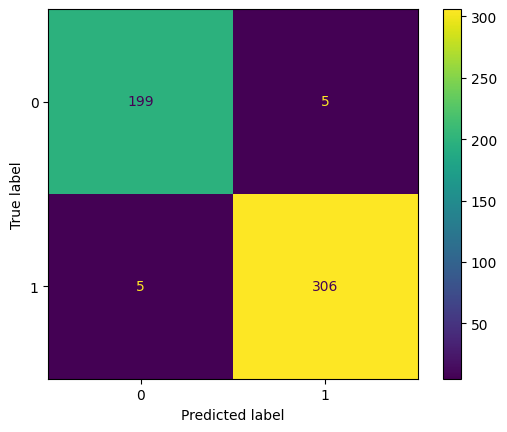

In [ ]:
# Let's say Logistic Regression performed best
best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_train_tfidf, y_train)

# Detailed evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(LogisticRegression(), parameters, cv=5)
grid_search.fit(X_train_tfidf, y_train)

print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
import joblib
import pickle

# Save the model
joblib.dump(best_model, 'ecommerce_classifier.pkl')

# Save the vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [ ]:
def predict_ecommerce(text):
    # Load model and vectorizer
    model = joblib.load('ecommerce_classifier.pkl')
    with open('tfidf_vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)

    # Preprocess
    cleaned_text = preprocess_text(text)

    # Vectorize
    text_vector = vectorizer.transform([cleaned_text])

    # Predict
    prediction = model.predict(text_vector)
    probability = model.predict_proba(text_vector)

    return {
        'prediction': 'Ecommerce' if prediction[0] == 1 else 'Not Ecommerce',
        'confidence': max(probability[0])
    }

# Test your function
print(predict_ecommerce("When will my order arrive?"))
print(predict_ecommerce("What's the weather today?"))

{'prediction': 'Ecommerce', 'confidence': np.float64(0.7772872626489475)}
{'prediction': 'Not Ecommerce', 'confidence': np.float64(0.8185411420803633)}


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch

# Load pre-trained model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Tokenize your data
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# Create dataset
class EcommerceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EcommerceDataset(train_encodings, y_train)
test_dataset = EcommerceDataset(test_encodings, y_test)

# Updated Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    eval_strategy="epoch",  # Changed from evaluation_strategy to eval_strategy
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch"
)

# Train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pratham-shinde-282005 (pratham-shinde-282005-techiolaza-innovations) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.050700,0.059989
2,0.042500,0.054903
3,0.031600,0.063208


Epoch,Training Loss,Validation Loss
1,0.050700,0.059989
2,0.042500,0.054903
3,0.031600,0.063208


TrainOutput(global_step=387, training_loss=0.0783010123283133, metrics={'train_runtime': 2014.605, 'train_samples_per_second': 3.066, 'train_steps_per_second': 0.192, 'total_flos': 71916602475420.0, 'train_loss': 0.0783010123283133, 'epoch': 3.0})

In [ ]:
from flask import Flask, request, jsonify
import joblib
import pickle

app = Flask(__name__)

# Load model and vectorizer
model = joblib.load('ecommerce_classifier.pkl')
with open('tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    text = data['text']

    # Preprocess
    cleaned_text = preprocess_text(text)

    # Vectorize
    text_vector = vectorizer.transform([cleaned_text])

    # Predict
    prediction = model.predict(text_vector)[0]
    probability = model.predict_proba(text_vector)[0]

    return jsonify({
        'prediction': int(prediction),
        'confidence': float(max(probability))
    })

if __name__ == '__main__':
    app.run(debug=True)

FileNotFoundError: [Errno 2] No such file or directory: 'ecommerce_classifier.pkl'

In [ ]:
from flask import Flask, request, jsonify
import joblib
import pickle

app = Flask(__name__)

# Load model and vectorizer
model = joblib.load('ecommerce_classifier.pkl')
with open('tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

@app.route('/predict', methods=['POST'])
def predict():
    # Get and validate input
    data = request.get_json()
    if not data or 'text' not in data:
        return jsonify({"error": "Missing 'text' in request"}), 400

    text = data['text']

    # Vectorize (add preprocessing here if needed)
    try:
        text_vector = vectorizer.transform([text])
        prediction = model.predict(text_vector)[0]
        probability = model.predict_proba(text_vector)[0].max()

        return jsonify({
            "prediction": int(prediction),
            "confidence": float(probability)
        })

    except Exception as e:
        return jsonify({"error": str(e)}), 500

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=True)

FileNotFoundError: [Errno 2] No such file or directory: 'ecommerce_classifier.pkl'

In [ ]:
import joblib
import pickle
# Load model, vectorizer, label encoder
model = joblib.load('ecommerce_classifier.pkl')
vectorizer = pickle.load(open('tfidf_vectorizer.pkl', 'rb'))
label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))

# Test input
text = "I want to cancel my order"

# Vectorize
text_vector = vectorizer.transform([text])
pred = model.predict(text_vector)[0]
intent = label_encoder.inverse_transform([pred])[0]
confidence = model.predict_proba(text_vector)[0].max()

print("Prediction:", intent)
print("Confidence:", confidence)


FileNotFoundError: [Errno 2] No such file or directory: 'ecommerce_classifier.pkl'

In [ ]:
!python /content/train_model.py

✅ Model trained and saved successfully.


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import joblib
import pickle

# 🔹 Load model, vectorizer, and label encoder from Google Drive path
model = joblib.load('/content/drive/MyDrive/ecommerce-intent-model/ecommerce_classifier.pkl')
vectorizer = pickle.load(open('/content/drive/MyDrive/ecommerce-intent-model/tfidf_vectorizer.pkl', 'rb'))
label_encoder = pickle.load(open('/content/drive/MyDrive/ecommerce-intent-model/label_encoder.pkl', 'rb'))

print("✅ All model components loaded successfully!")


✅ All model components loaded successfully!


In [ ]:
# 🔹 Sample input for prediction
text = "I want to cancel my order"

# 🔹 Preprocess and predict
vector = vectorizer.transform([text])
pred = model.predict(vector)[0]
intent = label_encoder.inverse_transform([pred])[0]
confidence = model.predict_proba(vector)[0].max()

# 🔹 Output
print("🧠 Prediction:", intent)
print("✅ Confidence:", round(confidence * 100, 2), "%")


🧠 Prediction: cancel_order
✅ Confidence: 33.28 %
